<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [le zip](https://drive.google.com/file/d/1Hw7gjd0cZQGi258_aosxPfC-RTSkcqJt/view?usp=sharing) dans Google Drive
- Modifier les chemins des fichiers (zip_path et extract_path) dans le code


---

 ## **Contexte et description du notebook**

L'objectif de Seattle est de devenir une ville neutre en émissions de carbone en 2050. La ville s'intéresse particulièrement aux consommations énergétiques et aux émissions de carbone des bâtiments qui ne sont pas destinés à l'habitation.

Néanmoins, ces 2 types de données ne sont pas disponibles pour tous les bâtiments. L'objectif ici est de prédire la consommation énergétique et l'émission de carbone.

De plus, un focus sera effectué sur si la variable ENERGYSTARScore Score joue un rôle important dans la précision des prédictions des émissions de carbone.

Les variables TotalGHGEmissions et SiteEnergyUseWN ont été choisies pour respectivement mesurer la consommation énergétique et l'émission de carbone.

---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions auxiliaires**

### **III. Analyse exploratoire**

# **I. Installation et mise en place de l'environnement de travail**

In [268]:
# Importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

import datetime

In [269]:
# Informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-04-27T16:47:35.631274


In [270]:
# Configurations de l'affichages des données
pd.set_option('display.max_columns', None)

In [271]:
# Connexion au drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [272]:
# Verifier l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/2016_Building_Energy_Benchmarking.pq')
df.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,None,NaN,None,NaN,None,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,None,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,None,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,None,295.86,2.86


# **II. Définitions des fonctions et des variables globales**


In [273]:
# TARGET =
ID = 'OSEBuildingID'

In [274]:
def count_years_certified(year):
  if year == None:
    return 0
  elif len(year) == 4:
    return 1
  elif len(year) == 8:
    return 2
  else:
    power = year[8:]
    return((int(power) + 1)//4)

def last_year_certified(year):
    if year == None:
        return None
    elif len(year) in [4, 8]:
        return int(year[:4])
    else:
        return int(year[0] + year[2:5])

In [275]:
#supervisé! déterminer une va QUANTI, à partir de QUANTI et QUALI

# analyse EXPLORATOIRE rapide sans supprimer svp ?
## Describe
## Doublons
## Valeurs manquantes
##

# quelles sont les TARGETS?
 # Vous avez choisi la variable cible pour la consommation totale d’énergie,
 # Vous avez choisi la variable cible pour la consommation/EMISSION de CO2.

#NEW NOTEBOOK
# préchoix
 # choisir les colonnes pertinentes pour mon étude
  #catégorielle :
  #numérique :
  #potentielle transformation :
 # filtrer les lignes
    #btp non résidentiels
# voir donnée manquantes pour choix des variables aussi Héléna.

# nettoyage
 # type des variables
 # doublons
 # outlier (boxplot)
 # valeur non logique ou abérrante (règles de calculs et description de la table)
 # valeur manquante (graphique, imputation de valeurs, changement de valeur etc, voir distribution)
 # creation de nouvelles variables #proportion et nature des sources d'e utilisée #déduire qq chose d'une adresse ?
 # changement unité si nécessaire

# analyse exploratoire
 # statistique descriptive
 # distribution
 # statistique uni et bivarié (correlation)
 # check si pas de data leakage ie pas de corrélation trop forte entre cible et le reste

# préparation des données pour ML, variable a de l'impact ou pas?
 # normalisation des données
 # encodage
 # dataset de training

 # TARGET 1 - prédire une valeur numérique
#tester simple la régression lineaire

#NEW NOTEBOOK
# TARGET 1 - prédire une valeur numérique
#tester simple la régression lineaire

# entrainement modèle, pipeline, grid search
# choix de la méthode de scoring
# comparer les 4 modèles : ElasticNet, SVM, GradientBoosting, RandomForest
# si iverfitting : tester une méthode ensembliste (bagging, boosting)

# check impact de STAR SCORING avec et sans
#c'est pour comparer ce qui est comparable. ENtre BTP aux services similaires (école <> industrie)

#NEW NOTEBOOK
# TARGET 2 - prédire une valeur numérique
# entrainement modèle

#shap
#ElasticNet (lineaire, ), SVM, GradientBoosting, RandomForest).

#pour savoir si une va est importante ?
# simple : utiliser la lib black box
# compliqué : LASSO (connaissance de l'algo!), cas particulier de l'eslatic net, 0 sur tout



#YearBuilt = or total renovation
#PropertyGFATotal = surface occupée par tout le btp
#LargestPropertyUseType (selon surface)~~ ++PrimaryPropertyType (EPA: 'Environmental Protection Agency)
#ENERGYSTARScore: Une note de 50 représente la médiane nationale.
#Outlier si c'est un outilier parmi les btp
#ComplianceStatus btp a t il atteint le benchmarck ?
#GHGEmissionsIntensity : emission par unité de surface (TotalGHGEmissions)
#DefaultData ie par calcul automatique/replacement automatique

#NaturalGas(kBtu) conso de gaz par les services public
#Electricity(kBtu) conso total de elect
#SteamUse(kBtu) = utilisation de vapeur pour chauffage, industrie etc.

#SourceEUIWN(kBtu/sf) par surface : énergie totale nécessaire pour alimenter la propriété, y compris les pertes énergétiques associées à la production et à la distribution.
#SiteEUIWN(kBtu/sf) par surface : l'énergie consommée par la propriété là où elle est utilisée.
#SiteEnergyUseWN(kBtu) : Il s'agit de la quantité annuelle d'énergie consommée par la propriété provenant de toutes les sources d'énergie

# **III. Analyse exploratoire**

**EXPLICATION DES VARIABLES CHOISIE DANS LE CONTEXTE DE LA MESURE ENERGETIQUE**

**Emission de carbone: TotalGHGEmissions** :

Quantité totale d'émission de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l'oxyde nitreux, rejetée dans l'atmosphère à la suite de la consommation d'énergie sur le site, mesurée en tonne d'équivalent dioxyde de carbone.

**Consommation énergétique: SiteEnergyUse(kBtu)** :

Consommation énergétique sur site, toutes énergies confondues. En Kilo d'unités thermiques britanniques


On cherche à prédire les variables:
- émissions de CO2 (GHGEmissionsIntensity) NOTEBOOK1
- consommation totale d’énergie (SiteEnergyUseWN) NOTEBOOK2

TARGET1 =
TARGET2= va globale

ENERGY STAR ⁉

destiné aux btp commerciaux. score de 1 à 100. 50=médiane,

utilité ? gommer les différences lié à l'activité, ou aux sources d'e, pouvoir comparer des btp comparable (LargestPropertyUseType).

##**DIMENSIONS ET STATISTIQUES GENERALES DES VARIABLES**

In [276]:
# Dimensions
nRow, nCol  = df.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol)

NB DE LIGNES   : 3376
NB DE COLONNES : 46


In [277]:
# Nom des colonnes
print("LISTE DES COLONNES :")
df.columns

LISTE DES COLONNES :


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [278]:
# Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,43,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


In [279]:
# Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376,3376,3360,3376,3376,3376,3376,3368,3376,3376,3376,3376,3356,1679,596,2533,3369,3370,3367,3367,3371,3370,3367,3367,3367,3367,3367,0,3367,3367
mean,21209,2016,98117,4,48,-122,1969,1,5,94834,8002,86832,79178,28444,11739,68,55,57,134,138,5403667,5276726,274596,1086639,3707612,13685,1368505,nan,120,1
std,12224,0,19,2,0,0,33,2,5,218838,32327,207940,201703,54393,29331,27,56,57,139,139,21610629,15938786,3912173,4352478,14850656,67098,6709781,nan,539,2
min,1,2016,98006,1,47,-122,1900,0,0,11285,0,3636,5656,0,0,1,0,0,0,-2,0,0,0,-33827,-115417,0,0,nan,-1,-0
25%,19991,2016,98105,3,48,-122,1948,1,2,28487,0,27756,25095,5000,2239,53,28,29,75,78,925129,970182,0,187423,639487,0,0,nan,9,0
50%,23112,2016,98115,4,48,-122,1975,1,4,44175,0,43216,39894,10664,5043,75,39,41,96,101,1803753,1904452,0,345130,1177583,3238,323754,nan,34,1
75%,25994,2016,98122,7,48,-122,1997,1,5,90992,0,84276,76200,26640,10139,90,60,64,144,148,4222455,4381429,0,829318,2829632,11890,1189034,nan,94,1
max,50226,2016,98272,7,48,-122,2015,111,99,9320156,512608,9320156,9320156,686750,459748,100,834,834,2620,2620,873923712,471613856,134943456,192577488,657074389,2979090,297909000,nan,16871,34


In [280]:
# Type des variables
print("TYPE DES VARIABLES :\n")
df.dtypes

TYPE DES VARIABLES :



OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

La majorité des types ont été bien importés sauf pour :
- YearsENERGYSTARCertified
- ZipCode, CouncilDistrictCode

**DOUBLONS ET VALEURS MANQUANTES**

In [281]:
# Doublons selon l'ID du bâtiment
print('Nb de doublons: ', df['OSEBuildingID'].isna().sum(axis=0))

Nb de doublons:  0


VALEURS MANQUANTES :
                                   NB      %
Comments                         3376  100.0
Outlier                          3344   99.0
YearsENERGYSTARCertified         3257   96.0
ThirdLargestPropertyUseType      2780   82.0
ThirdLargestPropertyUseTypeGFA   2780   82.0
SecondLargestPropertyUseTypeGFA  1697   50.0
SecondLargestPropertyUseType     1697   50.0
ENERGYSTARScore                   843   25.0
LargestPropertyUseTypeGFA          20    1.0
LargestPropertyUseType             20    1.0
NaturalGas(kBtu)                    9    0.0
SiteEUIWN(kBtu/sf)                  6    0.0
TotalGHGEmissions                   9    0.0
ComplianceStatus                    0    0.0
SiteEUI(kBtu/sf)                    7    0.0
SourceEUI(kBtu/sf)                  9    0.0
NaturalGas(therms)                  9    0.0
SourceEUIWN(kBtu/sf)                9    0.0
SiteEnergyUse(kBtu)                 5    0.0
DefaultData                         0    0.0
SteamUse(kBtu)                    

Text(0.5, 1.0, 'Matrice des valeurs manquantes\n')

<Figure size 1000x500 with 0 Axes>

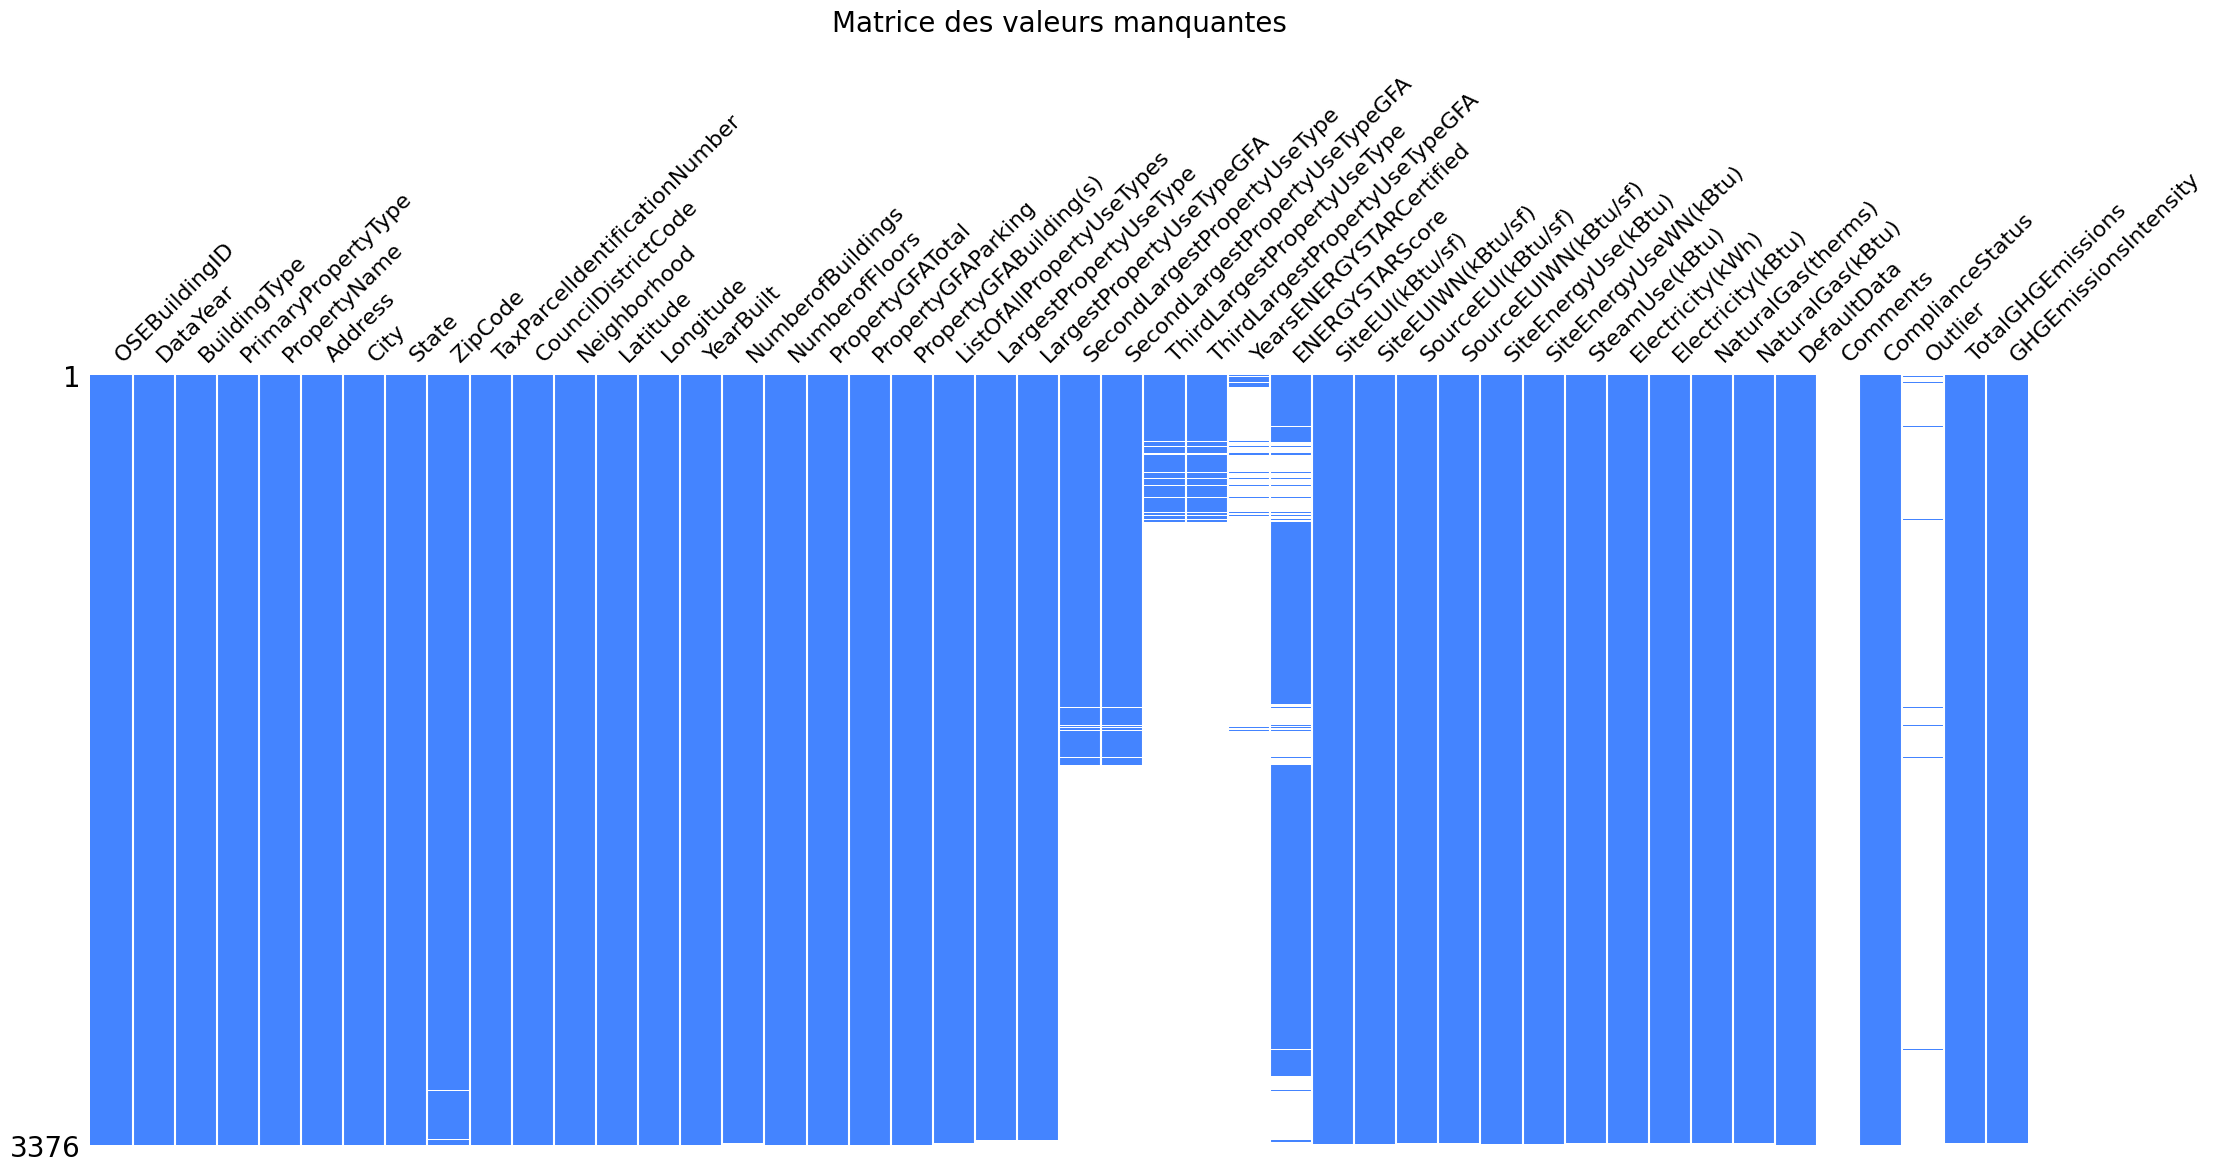

In [282]:
# Valeurs manquantes
missing_values_count = df.isna().sum()
missing_values_percent = round(df.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

# Représentons graphiquement les données manquantes
plt.figure(figsize=(10, 5))
msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
           ).set_title("Matrice des valeurs manquantes\n", fontsize = 20)

## **NETTOYAGE DU JEU DE DONNEES**

**CONSERVER LES BATIMENTS NON RESIDENTIELS**

In [283]:
# Lister les types de bâtiments
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [284]:
# Conserver uniquement les bâtiments non résidentiels
non_residential_buildings = [b for b in df['BuildingType'].unique() if 'nonresidential' in b.lower()]
df = df.loc[df['BuildingType'].isin(non_residential_buildings)]

In [285]:
# Vérifier l'usage principal des batiments
df['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  495
Non-Refrigerated Warehouse                              199
Retail Store                                             97
Other                                                    91
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              39
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/Universit

In [286]:
# Retirer les bâtiments indiqués comme résidentiel
residential_use=['Residence Hall/Dormitory', 'Multifamily Housing', 'Residential Care Facility', 'Other - Lodging/Residential']
df = df.loc[~df['LargestPropertyUseType'].isin(residential_use)]

**RETIRER LES BATIMENTS ATYPIQUES**

In [287]:
# Le statut de conformité indique si un bâtiment satisfait aux exigences de référencement énergétique pour l'année en cours
df['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       1476
Non-Compliant                     17
Error - Correct Default Data      13
Missing Data                       1
Name: count, dtype: int64

In [288]:
## Je conserve uniquement les bâtiments Compliant
df = df.loc[df['ComplianceStatus'] == 'Compliant']

# Je supprime la colonne car elle ne contient plus d'informations intéressantes
df.drop(columns=['ComplianceStatus'], inplace=True)

In [289]:
# Indique si les bâtiments sont des outliers
print(df['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


In [290]:
# Les batiments outilier ont été filtrés en amont
# Je supprime la colonne
df.drop(columns=['Outlier'], inplace=True)

**RETIRER LA COLONNE VIDE**

In [291]:
# Retirer la colonne vide
df.drop(columns='Comments', inplace=True)

**RETIRER LES VARIABLES PEU PERTINENTES**

In [292]:
# DefaultData indique si au moins une variable a été imputée automatiquement pour le bâtiment
## Vérification des valeurs pour la qualité de la base
percentage_true = df['DefaultData'].mean() * 100
print(f"% de bâtiments dont au moins une valeur a été imputée: {percentage_true:.2f}%")

# Je supprime car l'information n'est pas pertinente
df.drop(columns=['DefaultData'], inplace=True)

% de bâtiments dont au moins une valeur a été imputée: 0.00%


**CHOISIR LES VARIABLES DONT L'INFORMATION EST REDONDANTE**

In [293]:
# Pour identifier un batiment de manière unique, j'ai choisi OSEBuildingID
df.drop(columns=['PropertyName', 'TaxParcelIdentificationNumber'], inplace=True)

In [294]:
# Pour identifier la localisation, j'ai choisi Neighborhood:
## Pour limiter le nombre de variables, j'ai favorisé Neighborhood par rapport au couple (Latitude,Longitude) malgré une perte de précision
## Neighborhood peut être choisi car tous les bâtiments sont situés à Seattle
## Il manque des valeurs pour ZipCode donc j'ai favorisé Neighborhood
df.drop(columns=['Address', 'City', 'State', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude'], inplace=True)

In [295]:
# Pour mesurer les émissions de carbones, j'ai choisi TotalGHGEmissions:
## Car GHGEmissionsIntensity ne prend pas en compte la surface totale du bâtiment
df.drop(columns=['GHGEmissionsIntensity'], inplace=True)

In [296]:
# Pour mesurer la consommation énergétique, j'ai choisi SiteEnergyUse(kBtu):
## Car SourceEUIWN et SourceEUI prennent en compte les pertes liées à la production et au transport
## Car SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) ne prennent pas en compte la surface totale du bâtiment
## Car même si SiteEnergyUseWN(kBtu) retire les effets des variations climatique, les bâtiments sont dans la même ville avec un climat similaire
df.drop(columns=['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [297]:
# Pour mesurer les variables features, j'ai choisi les variables mesurées en kBtu:
## Car l'unité sera uniforme
df.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)'], inplace=True)

In [298]:
# On a déjà les 3 principaux utilisations de la propriété
missing_value = [(col, df[col].isna().sum()) for col in ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']]
print("missing values:\n", missing_value)

# On supprime
df.drop(columns=['ListOfAllPropertyUseTypes'], inplace=True)

missing values:
 [('ListOfAllPropertyUseTypes', 0), ('LargestPropertyUseType', 4)]


**FEATURE ENGINEERING**

In [299]:
# Je regarde s'il existe des valeurs abérantes
print(df['YearBuilt'].unique(), end='\n')
print(df['DataYear'].unique())

[1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1978 1906 1994 1955 1961 1900 1954 1911 1973 1920
 1910 1982 1908 1959 2000 1997 1962 1970 2008 1965 1929 2010 1990 1938
 1986 2002 1923 2003 1941 2006 1915 1950 1958 1971 2007 1951 1964 1953
 1937 1966 1957 1968 1924 2005 1931 1972 1952 1914 1981 1989 1925 1976
 2009 1909 1988 1979 1947 1984 1956 1912 1977 1960 1945 1992 1963 1974
 1975 1946 1995 1967 1987 1949 1940 1932 1948 1993 1918 1905 1902 1921
 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1913 1935 2011 2014
 2015]
[2016]


In [300]:
# Age du bâtiment qui remplace 2 variables et qui est plus explicite
df['Age'] = df['DataYear'] - df['YearBuilt']
df.drop(columns=['DataYear', 'YearBuilt'], inplace=True)
df['Age'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  55, 116,  62, 105,
        43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,  51,  87,
         6,  26,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,  45,
         9,  65,  52,  63,  79,  50,  59,  48,  92,  11,  85,  44,  64,
       102,  35,  27,  91,  40,   7, 107,  28,  37,  69,  32,  60, 104,
        39,  56,  71,  24,  53,  42,  41,  70,  21,  49,  29,  67,  76,
        84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74, 113,   4,
         3,  97, 115,  80, 103,  81,   5,   2,   1])

In [301]:
# Perte d'informations à cause du format de données
to_check = 'YearsENERGYSTARCertified'
print('raw:\n', df[to_check].unique(), end='\n\n')
print(df[to_check].dtypes)

raw:
 [None '2016' '2014' '2012' '20172015' '2,0172E+39' '2,0102E+11'
 '2,0172E+11' '20162015' '2,0152E+19' '2,0122E+11' '2,0162E+35'
 '2,0162E+11' '2,0162E+19' '2,0162E+51' '2,0152E+11' '2,0142E+27'
 '2,0162E+15' '2,0172E+27' '2,0172E+23' '2,0152E+15' '2007' '2010'
 '2,0172E+19' '2,0172E+15' '2015' '2017' '2,0172E+35' '20092005'
 '2,0122E+15' '20112009' '2009' '2,0162E+23' '2,0162E+27' '20102008'
 '20162012' '2,0162E+31' '2,0142E+15' '2,0162E+59' '2011' '20172016'
 '2013' '20152012']

object


In [302]:
# Je peux déduire 2 informations:
## le nombre d'années où la certification a été obtenue
## la dernière année d'obtention du certificat

# Création des 2 nouvelles variables
df['LastYearENERGYSTARCertified'] = df['YearsENERGYSTARCertified'].apply(last_year_certified)
df['NbYearENERGYSTARCertified']   = df['YearsENERGYSTARCertified'].apply(count_years_certified)

# Vérifier la transformation
print(df['LastYearENERGYSTARCertified'].unique(), df['NbYearENERGYSTARCertified'].unique())

# Supprimer l'ancienne colonne
df.drop(columns=['YearsENERGYSTARCertified'], inplace=True)

[  nan 2016. 2014. 2012. 2017. 2010. 2015. 2007. 2009. 2011. 2013.] [ 0  1  2 10  3  5  9 13  7  4  6  8 15]


In [303]:
df.reset_index()

,index,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Age,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified
0,0,1,NonResidential,Hotel,DOWNTOWN,1.0,12,88434,0,88434,Hotel,88434.0,None,NaN,None,NaN,60.0,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,89,NaN,0
1,1,2,NonResidential,Hotel,DOWNTOWN,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86,20,NaN,0
2,2,3,NonResidential,Hotel,DOWNTOWN,1.0,41,956110,196718,759392,Hotel,756493.0,None,NaN,None,NaN,43.0,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,47,NaN,0
3,3,5,NonResidential,Hotel,DOWNTOWN,1.0,10,61320,0,61320,Hotel,61320.0,None,NaN,None,NaN,56.0,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,90,NaN,0
4,4,8,NonResidential,Hotel,DOWNTOWN,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01,36,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,3370,50221,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1.0,1,18261,0,18261,Other - Recreation,18261.0,None,NaN,None,NaN,NaN,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33,34,NaN,0
1472,3372,50223,Nonresidential COS,Other,DOWNTOWN,1.0,1,16000,0,16000,Other - Recreation,16000.0,None,NaN,None,NaN,NaN,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17,12,NaN,0
1473,3373,50224,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54,42,NaN,0
1474,3374,50225,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11,27,NaN,0


**NETTOYAGE DES MODALITES QUALITATIVES**

In [304]:
# vérification de la cohérence des données
to_check = 'Neighborhood'
print('raw:\n', df[to_check].unique(), end='\n\n')

# harmoniser les données
mapping = {
  'North': 'NORTH',
  'Delridge': 'DELRIDGE',
  'DELRIDGE NEIGHBORHOODS': 'DELRIDGE',
  'Northwest': 'NORTHWEST',
  'Ballard': 'BALLARD',
  'Central': 'CENTRAL'
}

df[to_check] = df[to_check].replace(mapping)
print(f'updated values in {to_check} :\n', df[to_check].unique())

raw:
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']

updated values in Neighborhood :
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE']


## **ANALYSE DES VARIABLES**

Les variables à prédire (TARGET) choisies sont:
- TotalGHGEmissions
- SiteEnergyUse(kBtu)

---

Les variables explicatives (FEATURES) choisies sont:

**CONSOMMATION ENERGETIQUE:**
- SteamUse(kBtu)
- Electricity(kBtu)
- NaturalGas(kBtu)
  

**ENERGIE SCORE:**
- ENERGYSTARScore
- LastYearENERGYSTARCertified
- NbYearENERGYSTARCertified

**CARACTERISTIQUES PHYSIQUES DU BATIMENT**
- NumberofBuildings
- NumberofFloors
- PropertyGFATotal
- PropertyGFAParking
- PropertyGFABuilding(s)
- LargestPropertyUseTypeGFA
- SecondLargestPropertyUseTypeGFA
- ThirdLargestPropertyUseTypeGFA

**UTILISATION DU BATIMENT**
- BuildingType
- PrimaryPropertyType
- LargestPropertyUseType
- SecondLargestPropertyUseType
- ThirdLargestPropertyUseType

**LOCALISATION GEOGRAPHIQUE ET AGE**
- Neighborhood
- Age


In [305]:
#Analyse Univariée
#Analyse Bivariée

##**ANALYSE UNIVARIEE**

**QUALITATIVES**

In [306]:
# Statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType
count,1476,1476,1476,1472,811,328
unique,3,19,13,51,47,38
top,NonResidential,Small- and Mid-Sized Office,DOWNTOWN,Office,Parking,Office
freq,1395,286,338,483,321,48


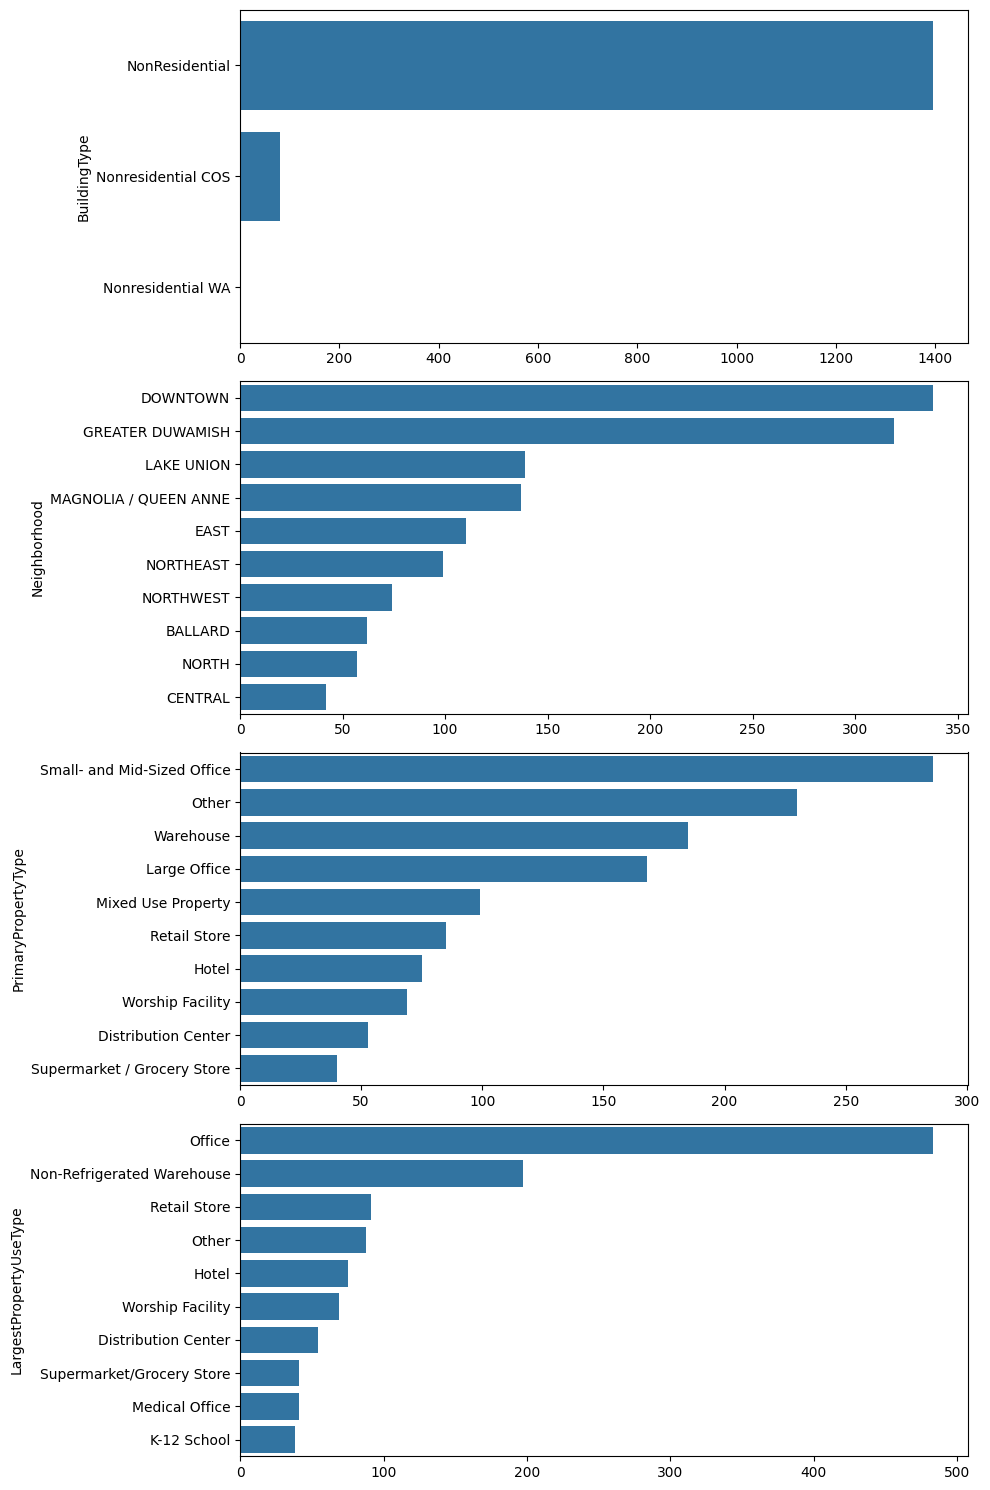

In [307]:
# TOP 10 des modalités de chaque variable qualitative
L = ['BuildingType', 'Neighborhood', 'PrimaryPropertyType', 'LargestPropertyUseType']
fig, axes = plt.subplots(nrows=len(L), ncols=1, figsize=(10,15))

for i, col in enumerate(L):
  df_graph = df[col].value_counts().sort_values(ascending=False)
  sns.barplot(x=df_graph[:10].values, y=df_graph[:10].index, ax=axes[i])

plt.tight_layout()
plt.show()

**QUANTITATIVES**

In [308]:
# Statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,Age,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified
count,1476,1476,1476,1476,1476,1476,1472,811,328,961,1476,1476,1476,1476,1476,1476,91,1476
mean,16263,1,4,112802,14246,98556,91490,35296,13136,63,7823348,514091,5550806,1711724,169,55,2015,0
std,13760,1,7,190845,44525,166754,157016,62696,27697,29,19007112,5425482,13254506,5620035,583,33,3,1
min,1,0,0,11285,0,3636,5656,0,0,1,57133,0,-115417,0,-1,1,2007,0
25%,601,1,1,28817,0,27900,25016,5404,2556,43,1223105,0,725989,0,20,28,2014,0
50%,21142,1,2,47978,0,45853,41604,12000,5626,70,2687720,0,1711462,442087,49,51,2016,0
75%,24582,1,4,103599,0,93569,89325,31190,12087,88,7253381,0,5238197,1437831,142,86,2017,0
max,50226,9,99,1952220,512608,1765970,1680937,441551,303910,100,293090784,134943456,274532495,138191238,12307,116,2017,15


###**CONSOMMATION ENERGETIQUE ET EMISSION DE CARBONE**

In [309]:
# L_num = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
# fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

# for i, col in enumerate(L_num):
#   df_graph = df[col]
#   sns.histplot(x=df_graph, ax=axes[i])

# plt.tight_layout()
# plt.show()

In [310]:
# L_num = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
# fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

# for i, col in enumerate(L_num):
#   df_graph = df[col]
#   sns.histplot(x=df_graph, ax=axes[i])

# plt.tight_layout()
# plt.show()

### **ENERGIE SCORE**


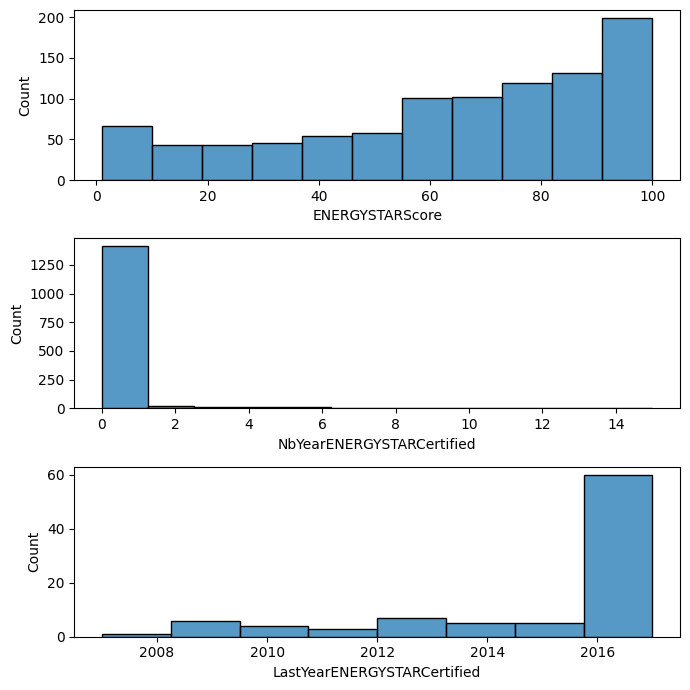

In [311]:
L_num = ['ENERGYSTARScore', 'NbYearENERGYSTARCertified', 'LastYearENERGYSTARCertified']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(7,7))

for i, col in enumerate(L_num):
  df_graph = df[col]
  sns.histplot(x=df_graph, ax=axes[i])

plt.tight_layout()
plt.show()

In [312]:
# # Exporter le fichier nettoyé
# df.to_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.parquet')